## Earning predictions

The aim of project was to predict if a person will earn more than 50 000 USD.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)
from sklearn.model_selection import KFold, StratifiedKFold,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
%time train = pd.read_hdf('train.adult.h5')

Wall time: 1.29 s


In [3]:
train.sample(5)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
18912,24,NaN,412156,HS-grad,9,Married-civ-spouse,NaN,Wife,White,False,0,0,40,Mexico,<=50K
1372,43,Private,221550,Masters,14,Never-married,Other-service,Not-in-family,White,False,0,0,30,Poland,<=50K
19761,29,Private,114801,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,40,United-States,<=50K
16661,26,Private,166666,Some-college,10,Never-married,Other-service,Not-in-family,White,False,0,0,35,United-States,<=50K
19680,28,Private,64307,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,True,0,0,40,United-States,<=50K


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [5]:
train.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,423.516600,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,3363.342471,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,-31441.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,27828.000000,4356.000000,99.000000


### EDA

In [6]:
np.sum(train.isnull())

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education-Num        0
Martial Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Country            583
Target               0
dtype: int64

There are missing values for three features: Workclass, Occupation, Country.

In [7]:
train['Target_cat']=train['Target'].apply(lambda x: 1 if x=='>50K' else 0)
black=['Target_cat','Target']
continous=[x for x in train.select_dtypes(include=['float','int8','int16','int64']) if x not in black]
cat =[x for x in train.select_dtypes(include=['object']) if x not in black]

print('continous: ', continous)
print('categorical: ',cat)

continous:  ['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical:  ['Workclass', 'Education', 'Martial Status', 'Occupation', 'Relationship', 'Race', 'Country']


In [8]:
for x in cat:
    print(train[x].value_counts(dropna=False,normalize=True),'\n')

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
NaN                 0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: Workclass, dtype: float64 

HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: Education, dtype: float64 

Married-civ-spouse       0.459937
Never-married            0.328092
Divorced                 0.136452
Separated                0.031479
Widowed                  0.030497
Married-spouse-absent    0.012837
Married-AF-spouse        0.000706
Name: Martial Status, dtype: floa

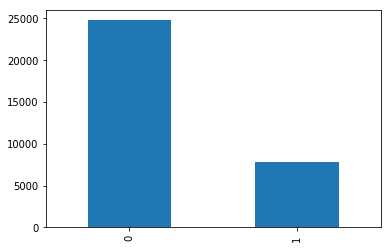

In [9]:
train['Target_cat'].value_counts(dropna=False).plot(kind='bar')

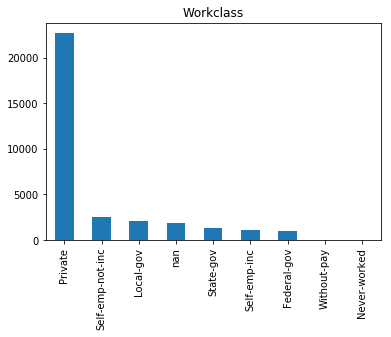

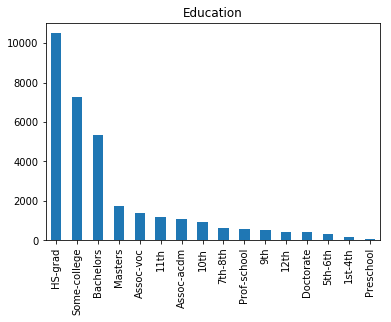

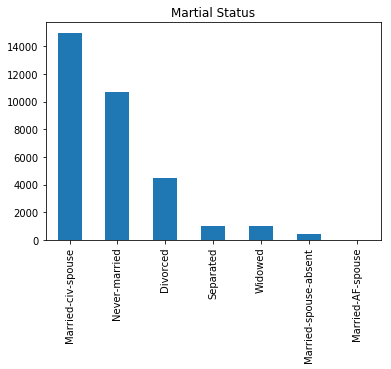

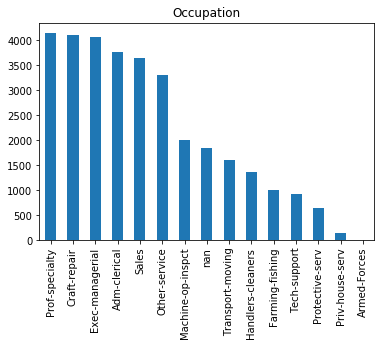

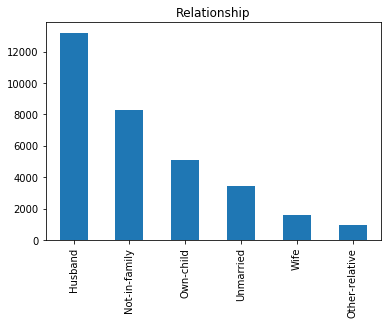

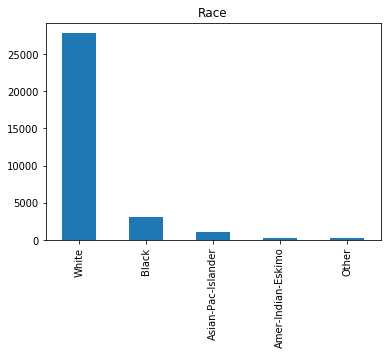

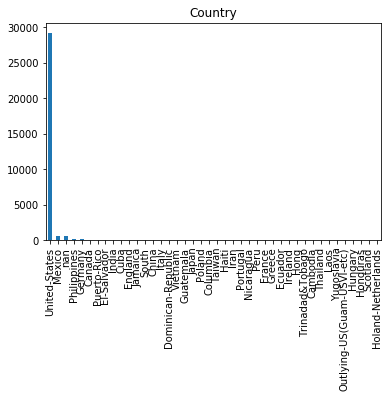

In [10]:
for x in cat:
    plt.show()
    train[x].value_counts(dropna=False).plot(kind='bar',title=x)

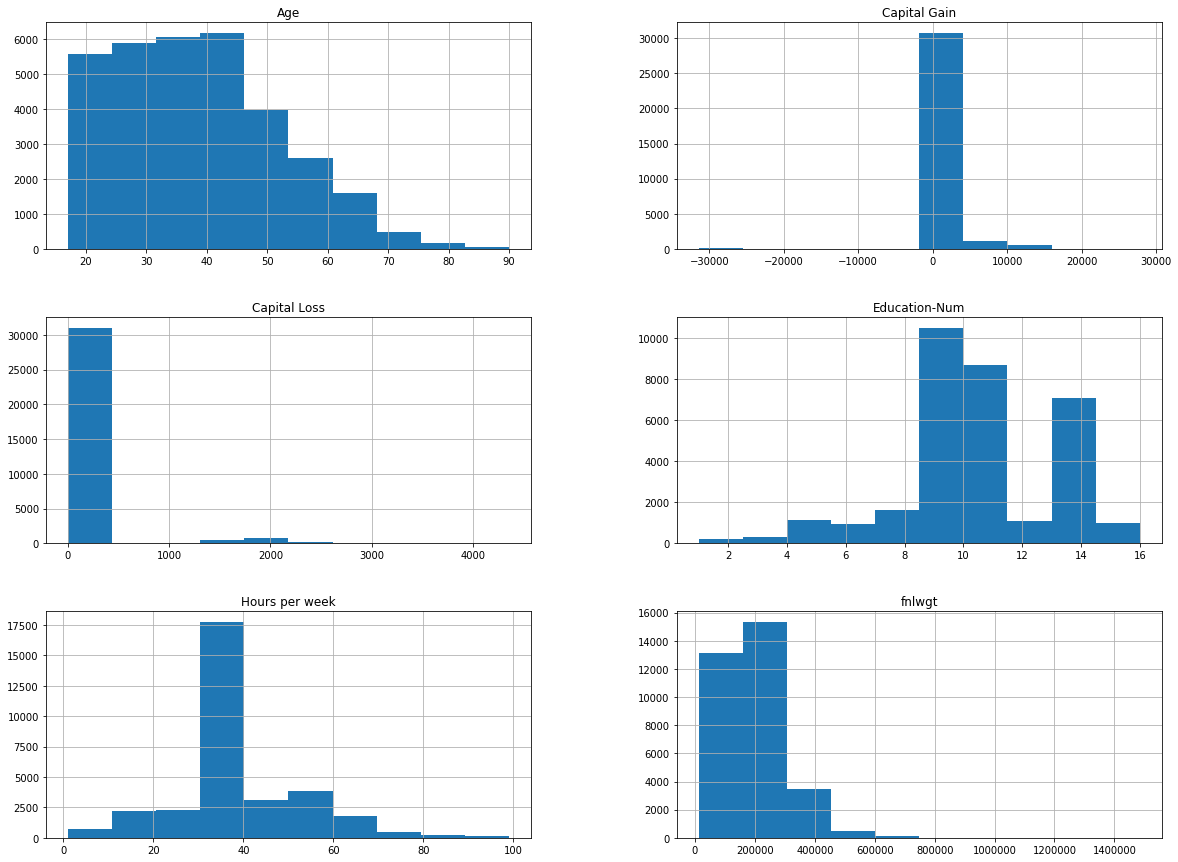

In [11]:
train[continous].hist(figsize=(20,15))
plt.show()

In [12]:
for x in cat:
    print('{}: {}'.format(x,train[x].nunique(dropna=False)))

Workclass: 9
Education: 16
Martial Status: 7
Occupation: 15
Relationship: 6
Race: 5
Country: 42


Conclusions:
- two target categories (unbalanced data)
- some features might be not important due to lack of diversity (for example country, race)
- distribution is skewed for majority of features
- diversity in categories is rather small (not many unique values)

Histogram of capital gain and loss without zero values.

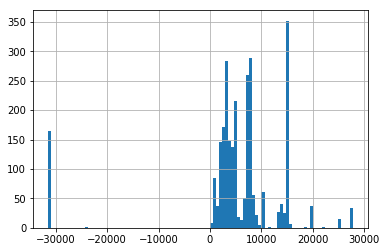

In [13]:
train[train['Capital Gain']!=0]['Capital Gain'].hist(bins=100)

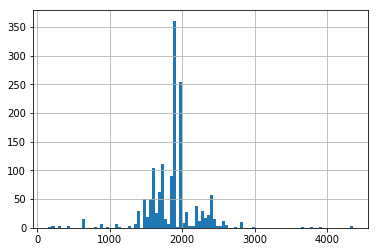

In [14]:
train[train['Capital Loss']!=0]['Capital Loss'].hist(bins=100)

#### Correlations

In [15]:
cor=train.corr(method='spearman')
cor['Target_cat'].sort_values()

fnlwgt           -0.010738
Capital Loss      0.141042
Sex               0.215980
Capital Gain      0.216352
Hours per week    0.269075
Age               0.272962
Education-Num     0.329682
Target_cat        1.000000
Name: Target_cat, dtype: float64

Correlation is rather week, education-num have highest value what is correct with intuition.

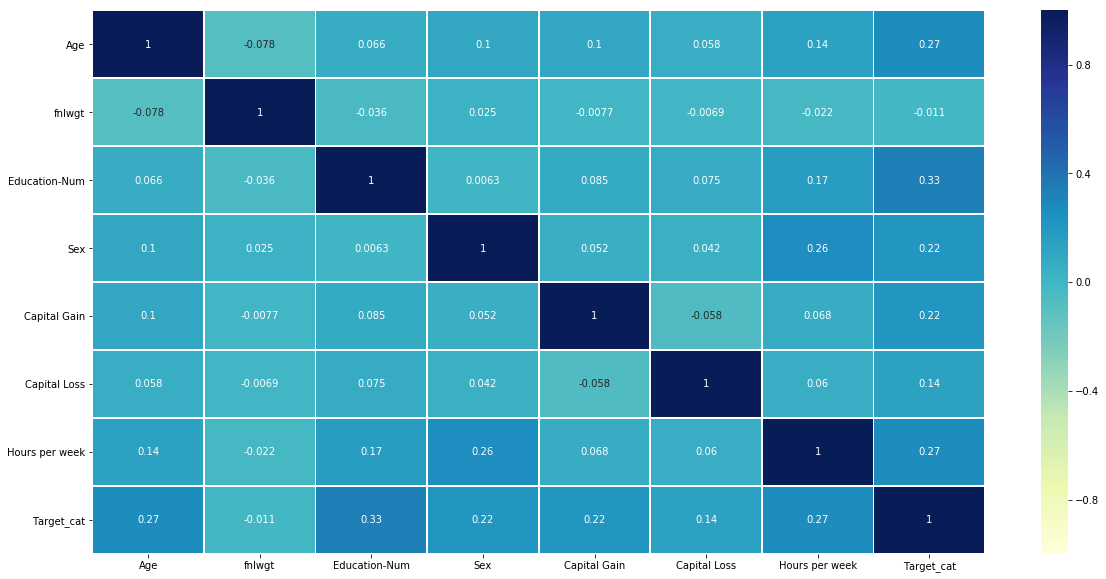

In [16]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train.corr(method='spearman'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

#### Visualisation

Some visualizations have been prepared in order to find interesting dependencies between features which might be useful.

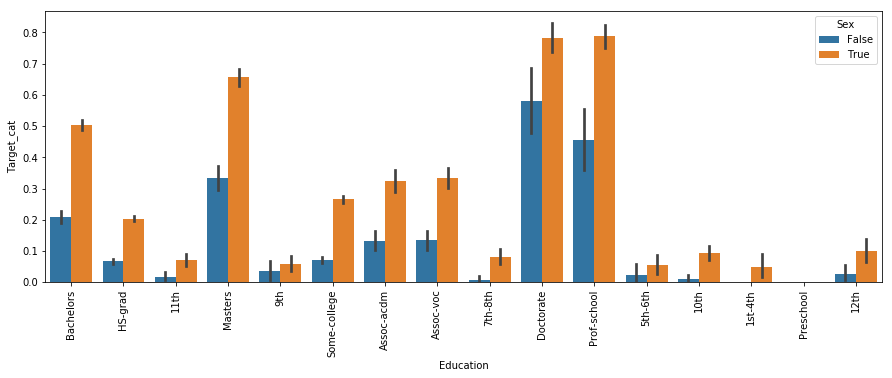

In [17]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Education", y="Target_cat", hue='Sex', data=train)
plt.xticks(rotation=90);

Education might have strong impact on target variable.

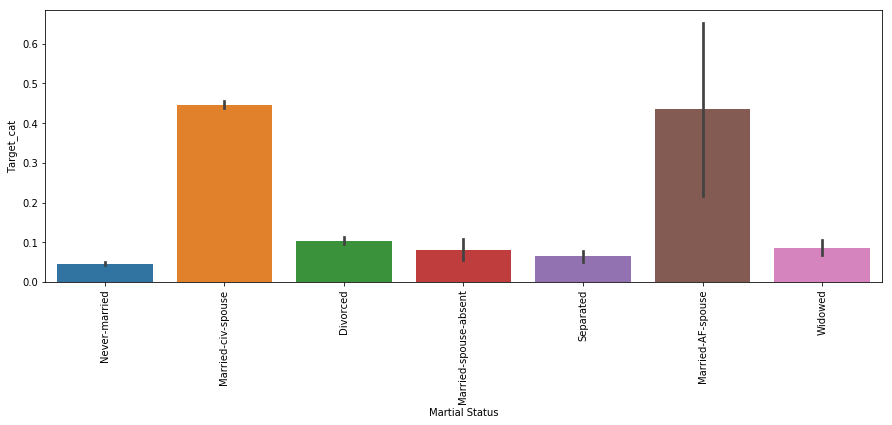

In [18]:
plt.figure(figsize=(15, 5))
sns.barplot(x='Martial Status', y="Target_cat", data=train)
plt.xticks(rotation=90);

It can be interpreted that married tends to earn much more, however married AF sposue categorie has low level of significance.

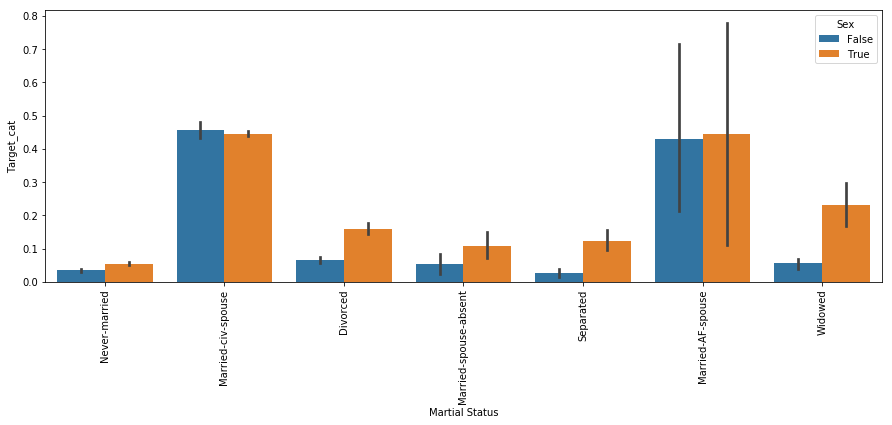

In [19]:
plt.figure(figsize=(15, 5))
sns.barplot(x='Martial Status', y="Target_cat", hue='Sex', data=train)
plt.xticks(rotation=90);

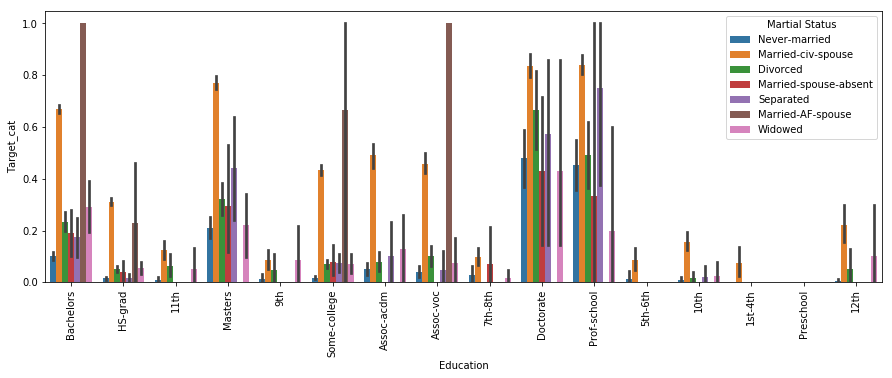

In [20]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Education", y="Target_cat", hue='Martial Status', data=train)
plt.xticks(rotation=90);

Education and martial-status might be a important feature, it is worth trying to combine these variables.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]), <a list of 73 Text xticklabel objects>)

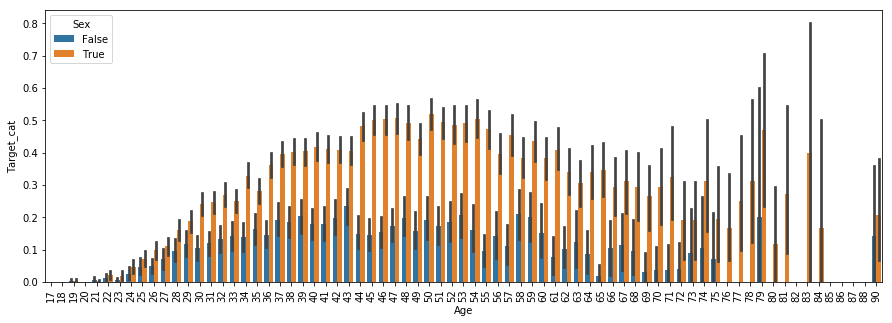

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Age", y="Target_cat", hue='Sex', data=train)
plt.xticks(rotation=90)

Age combined with sex and productive age gives much higher propabilities of earning more than 50k.

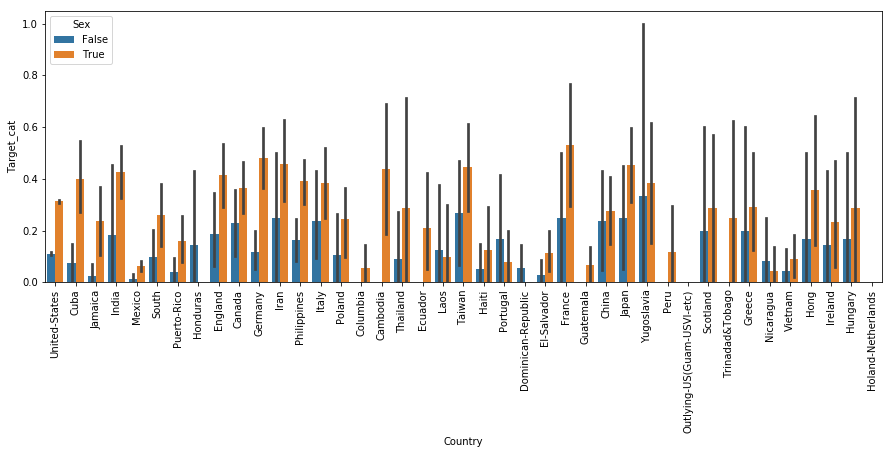

In [22]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Country", y="Target_cat", hue='Sex', data=train)
plt.xticks(rotation=90);

Due to lack of diversity country is not important variable

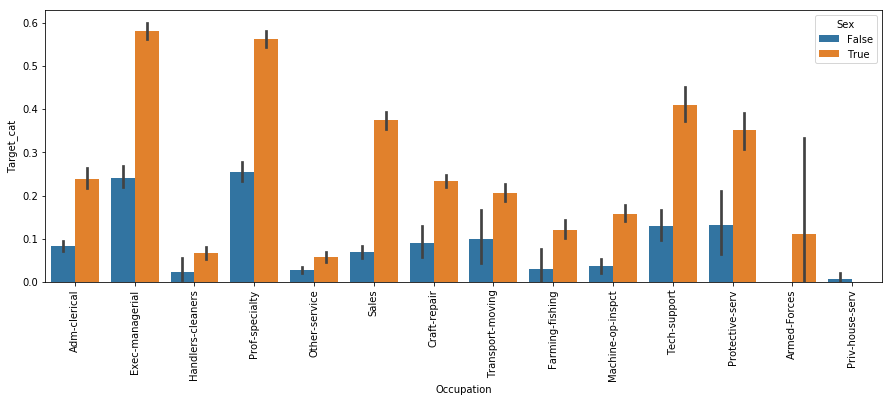

In [23]:
plt.figure(figsize=(15, 5))
sns.barplot(x='Occupation', y="Target_cat", hue='Sex', data=train)
plt.xticks(rotation=90);

<Figure size 1440x360 with 0 Axes>

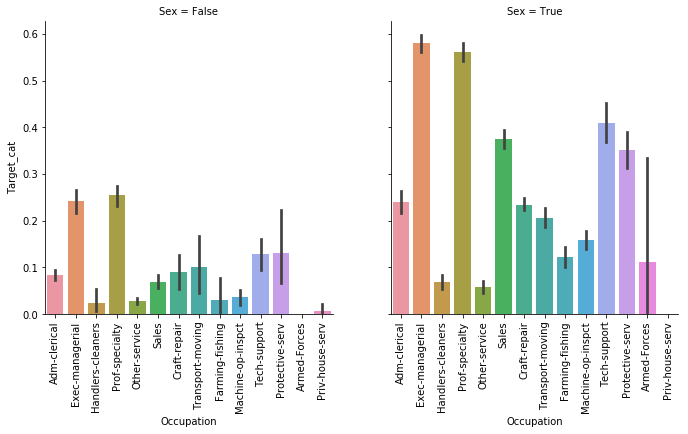

In [24]:
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Occupation", y="Target_cat", col="Sex", data=train, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

Men in combination with some occupations have higher propabibilities.

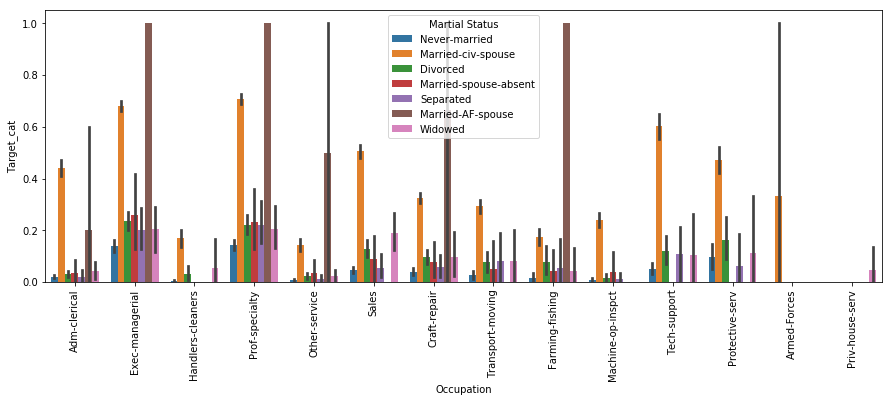

In [25]:
plt.figure(figsize=(15, 5))
sns.barplot(x='Occupation', y="Target_cat", hue='Martial Status', data=train)
plt.xticks(rotation=90);

### Models

In [27]:
X = train[continous].values 
y = train['Target_cat'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (22792, 6) (22792,)
Test: (9769, 6) (9769,)


In [29]:
def train_and_predict(model, X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)   
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    return np.round(accuracy_score(y_test, y_pred),3)

In [30]:
train_and_predict(DummyClassifier(random_state=2019), X, y, test_size=0.33)

0.631

Dummy classifier have about 63% of accuracy. Lets check some more advanced models:

In [31]:
X = train[continous].values 
y = train['Target_cat'].values

models=[LogisticRegression(solver='lbfgs',random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019)]
for m in models:
    print(type(m).__name__,train_and_predict(m, X, y, test_size=0.33))

LogisticRegression 0.787
DecisionTreeClassifier 0.769
RandomForestClassifier 0.811
XGBClassifier 0.837


It looks pretty well. Xgboost have about 84% of accuracy score. 

Now it is time for advanced models with more features. Cross validation has been performed using function presented below.

In [32]:
def model_train_predict (model, x, y, success_metric=accuracy_score):
    cv = StratifiedKFold(n_splits=10, random_state=2018, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(x,y):
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict (x.loc[test_idx])        
        score = success_metric(y[test_idx], y_pred )
        scores.append(score)      
    return np.round(np.mean(scores),3), np.round(np.std(scores),3)

In [33]:
df = pd.read_hdf('train.adult.h5')
df['target'] = df['Target'].factorize()[0]
df=df.fillna(-1)
df=df.drop_duplicates()
df=df.reset_index()

In [34]:
def feat_eng(df):
    cat_feats = df.select_dtypes(include=[np.object]).columns
    for cat_feat in cat_feats:
         df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]  
            
    df['White']=df['Race'].apply(lambda x: 1 if x=='White' else 0)
    df['Black']=df['Race'].apply(lambda x: 1 if x=='Black' else 0)
    df['Other_race']=df['Race'].apply(lambda x: 1 if  (x!='White') & (x!='Black') else 0)

    df['Extra_hours']=df['Hours per week'].map(lambda x: 1 if x>40 else 0)
    df['Extra_hours_num']=df['Hours per week'].map(lambda x: x-40 if x>40 else 0)

    df['Husband']=df['Relationship'].apply(lambda x: 1 if x=='Husband' else 0)
    df['Married-civ-spouse']=df['Martial Status'].apply(lambda x: 1 if x=='Married-civ-spouse' else 0)
    df['Never-married']=df['Martial Status'].apply(lambda x: 1 if x=='Never-married' else 0)

    df['Country_us']=df['Country'].apply(lambda x: 1 if x =='United-States' else 0)
    df['Country_other']=df['Country'].apply(lambda x: 1 if (x!='United-States') else 0)

    df['Occ_white']=pd.factorize(df[['Occupation_cat','White']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['White']),axis=1))[0]
    df['Occ_other']=pd.factorize(df[['Occupation_cat','Other_race']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['Other_race']),axis=1))[0]
    
    df['Productive_age']=df['Age'].apply(lambda x: 1 if (x >=24) & (x<=70) else 0)
    df['Master_bachelor']=df['Education'].apply(lambda x: 1 if (x =='Bachelors') | (x=='Masters') else 0)
    df['Doctor_prof']=df['Education'].apply(lambda x: 1 if (x =='Prof-school') | (x=='Doctorate') else 0)

    df['White_husband']=df[['Relationship','Race']].apply(lambda x: 1 if (x['Relationship']=='Husband') & (x['Race']=='White' ) else 0,axis=1)
    df['Black_husband']=df[['Relationship','Race']].apply(lambda x: 1 if (x['Relationship']=='Husband') & (x['Race']=='Black' ) else 0,axis=1)

    df['Occ_sex']=pd.factorize(df[['Occupation_cat','Sex']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['Sex']),axis=1))[0]
    df['Occ_rel_sex']=pd.factorize(df[['Occupation_cat','Relationship_cat','Sex']].apply(lambda x: '{0}-{1}-{2}'.format(x['Occupation_cat'], x['Relationship_cat'],x['Sex']),axis=1))[0]

    df['Married_productive']=pd.factorize(df[['Married-civ-spouse','Productive_age']].apply(lambda x: '{0}-{1}'.format(x['Married-civ-spouse'], x['Productive_age']),axis=1))[0]

    df['Occ_martial']=pd.factorize(df[['Occupation_cat','Martial Status']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['Martial Status']),axis=1))[0]
    df['Educ_martial']=df[['Education','Martial Status']].apply(lambda x: 1 if (((x['Education'] =='Assoc-voc') | (x['Education'] =='Bachelors')) & (x['Martial Status']=='Married-AF-spouse') ) else 0,axis=1)
    
    df['fnlwgt_log']=np.log2(df['fnlwgt']+1)
    
    return df

In [35]:
df_full=feat_eng(df)
feats = [    'Age', 'Education-Num', 'Extra_hours',
             'Husband','Married-civ-spouse','Never-married',
             'Occupation_cat','Occ_white','Occ_other',
             'Master_bachelor','Doctor_prof','Productive_age',
             'Capital Gain', 'Capital Loss','Relationship_cat',
             'White_husband','Black_husband',
             'Sex','White','Black','Other_race',
             'Country_us','Country_other','fnlwgt_log',
             'Occ_sex','Occ_rel_sex','Married_productive',
             'Occ_martial','Martial Status_cat', 'Educ_martial'
        ]
X = df_full[feats]
y = df_full['target']

In further analysis I've choosen best two models from previous experiment: RandomForestClassifier and XGBClassifier.

In [36]:
model_rf=RandomForestClassifier(max_depth=5, random_state=2019,n_estimators=100,max_features=20)
model_train_predict(model_rf, X, y,success_metric=accuracy_score)

(0.851, 0.005)

In [37]:
model_xgb=xgb.XGBClassifier(max_depth=5, random_state=2019,n_estimators=100,max_features=20)
model_train_predict(model_xgb, X, y,success_metric=accuracy_score)

(0.869, 0.004)

In both cases feature engineering results in imporoving accuracy. 

Learning curves have been analised in order to verify overfitting.

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ja\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

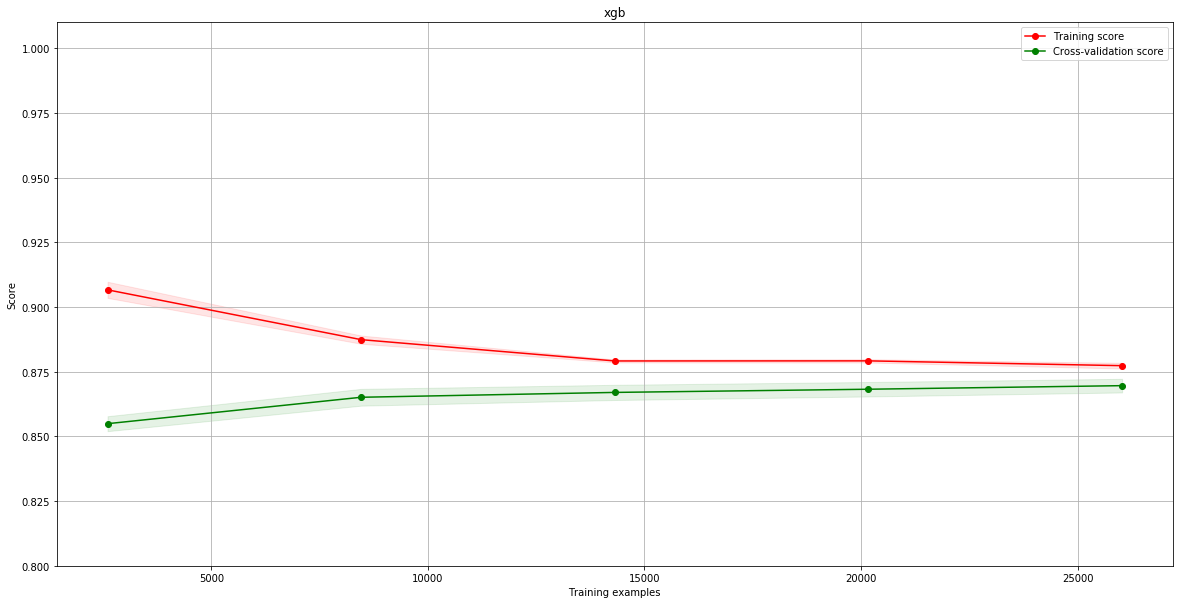

In [39]:
cv=StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)
plot_learning_curve(model_xgb, 'xgb', X, y, ylim=(0.8, 1.01), cv=cv)

<module 'matplotlib.pyplot' from 'C:\\Users\\ja\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

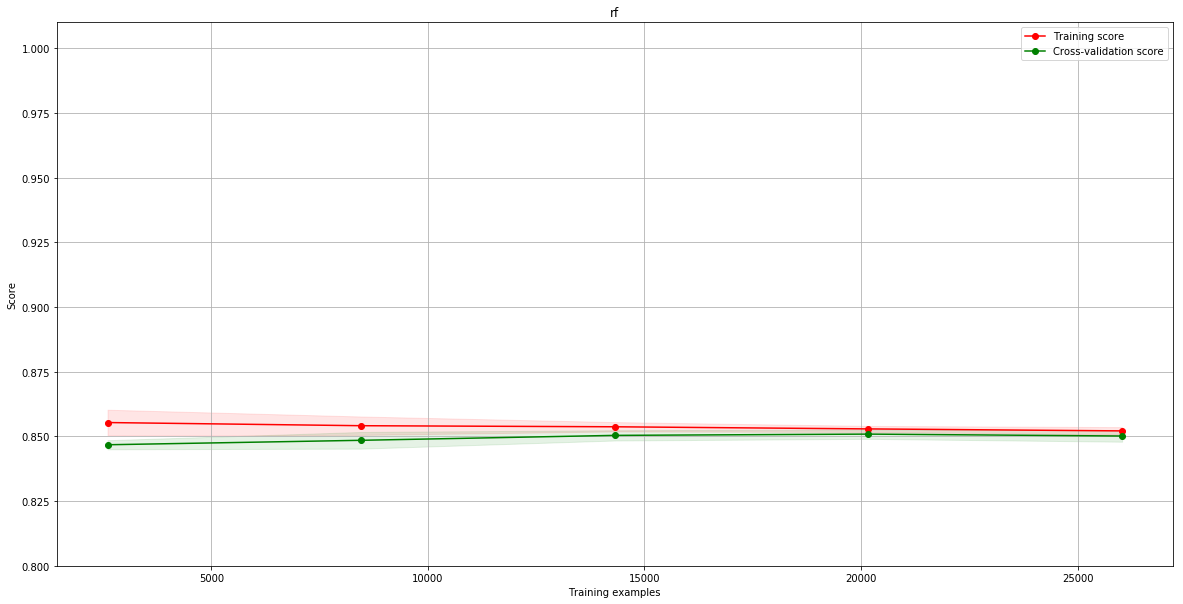

In [40]:
plot_learning_curve(model_rf, 'rf', X, y, ylim=(0.8, 1.01), cv=cv)

Learning curves look correctly. Models don't look like to be overfitted.

Last part of project concerns initial hiperparameter optimalization. Grid search has been used. 

In [56]:
param_grid = [{'n_estimators': [100,90,110], 'max_features': [0.6,0.8,1], 'max_depth':[9,7,5],'min_samples_split':[2,4]}]
forest_reg = RandomForestClassifier(random_state=2019)
grid_searchf = GridSearchCV(forest_reg, param_grid, cv=5,scoring='accuracy', return_train_score=True)
grid_searchf.fit(X, y)
sc = grid_searchf.best_score_
print('rf err: {}'.format(sc))
print('rf param: {}'.format(grid_searchf.best_params_))

rf err: 0.859698189753204
rf param: {'max_depth': 9, 'max_features': 0.8, 'min_samples_split': 4, 'n_estimators': 100}


In [43]:
param_grid = [{'n_estimators': [100,110,90], 'colsample_bytree': [0.6,0.8,1], 'max_depth':[9,7,5]}]
xg_reg = xgb.XGBClassifier(random_state=2019)
grid_search_xgb = GridSearchCV(xg_reg, param_grid, cv=5,scoring='accuracy', return_train_score=True)
grid_search_xgb.fit(X, y)
sc = grid_search_xgb.best_score_
print('xgb err: {}'.format(sc))
print('xgb param: {}'.format(grid_search_xgb.best_params_))

xgb err: 0.8701478316992962
xgb param: {'colsample_bytree': 0.6, 'max_depth': 7, 'n_estimators': 100}


In [44]:
model_rf=RandomForestClassifier(max_depth=grid_searchf.best_params_['max_depth'], random_state=2019,
                                n_estimators=grid_searchf.best_params_['n_estimators'],
                                max_features=grid_searchf.best_params_['max_features'],
                                min_samples_split=grid_searchf.best_params_['min_samples_split'])
model_train_predict(model_rf, X, y,success_metric=accuracy_score)

(0.86, 0.005)

In [45]:
model_xgb=xgb.XGBClassifier(max_depth=grid_search_xgb.best_params_['max_depth'], random_state=2019,
                            n_estimators=grid_search_xgb.best_params_['n_estimators'],
                            colsample_bytree=grid_search_xgb.best_params_['colsample_bytree'])
model_train_predict(model_xgb, X, y,success_metric=accuracy_score)

(0.87, 0.005)

Basic hiperparameter optimization allows to gain another improvement. It is worth considering to optimize more hiperparameters using for example hiperopt.